In [1]:
#coding=utf-8
import PyKDL as kdl
import matplotlib.pyplot as plt
from urdf_parser_py.urdf import URDF
# from pykdl_utils.kdl_parser import kdl_tree_from_urdf_model
import numpy as np
from scipy.spatial.transform import Rotation as R
import copy

In [2]:
def get_urdf_parameter(joint_id,xml_obj):
    """ get inertial data. """
    # mass = xml_obj.getElementsByTagName("mass")[joint_id].getAttribute("value")
    rpy  = xml_obj.getElementsByTagName("joint")[joint_id].getElementsByTagName("origin")[0].getAttribute("rpy").split(" ")
    rpy  = tuple([float(i) for i in rpy])
    axis  = xml_obj.getElementsByTagName("joint")[joint_id].getElementsByTagName("axis")[0].getAttribute("xyz").split(" ")
    axis  = np.array(axis,dtype=np.float32)
    xyz  = xml_obj.getElementsByTagName("joint")[joint_id].getElementsByTagName("origin")[0].getAttribute("xyz").split(" ")
    xyz  = np.array(xyz,dtype=np.float32)
    data = [axis, rpy,xyz]
    return data

In [3]:
from urdf_parser_py.urdf import Robot

def euler_to_quat(r, p, y):
    sr, sp, sy = np.sin(r/2.0), np.sin(p/2.0), np.sin(y/2.0)
    cr, cp, cy = np.cos(r/2.0), np.cos(p/2.0), np.cos(y/2.0)
    return [sr*cp*cy - cr*sp*sy,
            cr*sp*cy + sr*cp*sy,
            cr*cp*sy - sr*sp*cy,
            cr*cp*cy + sr*sp*sy]

def urdf_pose_to_kdl_frame(pose):
    pos = [0., 0., 0.]
    rot = [0., 0., 0.]
    if pose is not None:
        if pose.position is not None:
            pos = pose.position
        if pose.rotation is not None:
            rot = pose.rotation
    return kdl.Frame(kdl.Rotation.Quaternion(*euler_to_quat(*rot)),
                     kdl.Vector(*pos))

def urdf_joint_to_kdl_joint(jnt):
    origin_frame = urdf_pose_to_kdl_frame(jnt.origin)
    if jnt.joint_type == 'fixed':
        return kdl.Joint(jnt.name, kdl.Joint.Fixed)
    axis = kdl.Vector(*jnt.axis)
    if jnt.joint_type == 'revolute':
        return kdl.Joint(jnt.name, origin_frame.p,
                         origin_frame.M * axis, kdl.Joint.RotAxis)
    if jnt.joint_type == 'continuous':
        return kdl.Joint(jnt.name, origin_frame.p,
                         origin_frame.M * axis, kdl.Joint.RotAxis)
    if jnt.joint_type == 'prismatic':
        return kdl.Joint(jnt.name, origin_frame.p,
                         origin_frame.M * axis, kdl.Joint.TransAxis)
    # prin "Unknown joint type: %s." % jnt.joint_type
    return kdl.Joint(jnt.name, kdl.Joint.Fixed)

def urdf_inertial_to_kdl_rbi(i):
    origin = urdf_pose_to_kdl_frame(i.origin)
    rbi = kdl.RigidBodyInertia(i.mass, origin.p,
                               kdl.RotationalInertia(i.inertia.ixx,
                                                     i.inertia.iyy,
                                                     i.inertia.izz,
                                                     i.inertia.ixy,
                                                     i.inertia.ixz,
                                                     i.inertia.iyz))
    return origin.M * rbi

##
# Returns a PyKDL.Tree generated from a urdf_parser_py.urdf.URDF object.
def kdl_tree_from_urdf_model(urdf):
    root = urdf.get_root()
    tree = kdl.Tree(root)
    def add_children_to_tree(parent):
        if parent in urdf.child_map:
            for joint, child_name in urdf.child_map[parent]:
                child = urdf.link_map[child_name]
                if child.inertial is not None:
                    kdl_inert = urdf_inertial_to_kdl_rbi(child.inertial)
                else:
                    kdl_inert = kdl.RigidBodyInertia()
                kdl_jnt = urdf_joint_to_kdl_joint(urdf.joint_map[joint])
                kdl_origin = urdf_pose_to_kdl_frame(urdf.joint_map[joint].origin)
                kdl_sgm = kdl.Segment(child_name, kdl_jnt,
                                      kdl_origin, kdl_inert)
                tree.addSegment(kdl_sgm, parent)
                add_children_to_tree(child_name)
    add_children_to_tree(root)
    return tree

In [4]:
robot = URDF.from_xml_file("dofbot.urdf")

In [5]:
xml_string = robot.to_xml_string()
print(xml_string)
tree = kdl_tree_from_urdf_model(robot)

<?xml version="1.0" ?>
<robot name="dofbot" version="1.0">
  <link name="base_link">
    <visual>
      <origin xyz="0.0 0.0 0.0" rpy="0.0 0.0 0.0"/>
      <geometry>
        <mesh filename="package://dofbot_moveit/meshes/base_link.STL"/>
      </geometry>
      <material name="">
        <color rgba="0.7 0.7 0.7 1.0"/>
      </material>
    </visual>
    <collision>
      <origin xyz="0.0 0.0 0.0" rpy="0.0 0.0 0.0"/>
      <geometry>
        <mesh filename="package://dofbot_moveit/meshes/base_link.STL"/>
      </geometry>
    </collision>
  </link>
  <link name="link1">
    <visual>
      <origin xyz="0.0 0.0 0.0" rpy="0.0 0.0 0.0"/>
      <geometry>
        <mesh filename="package://dofbot_moveit/meshes/link1.STL"/>
      </geometry>
      <material name="">
        <color rgba="0.0 0.7 0.0 1.0"/>
      </material>
    </visual>
    <collision>
      <origin xyz="0.0 0.0 0.0" rpy="0.0 0.0 0.0"/>
      <geometry>
        <mesh filename="package://dofbot_moveit/meshes/link1.STL"/>
    

In [6]:
tree

base_link(q_nr: 0)
 	link1(q_nr: 0)
 	link2(q_nr: 1)
 	link3(q_nr: 2)
 	link4(q_nr: 3)
 	link5(q_nr: 4)
 	
	
	
	
	
	

In [7]:
def generate_random_pos(fk_solver):
    q = kdl.JntArray(5)
    q[0] = np.random.uniform(low=-np.pi, high=np.pi)
    q[1] = np.random.uniform(low=-np.pi, high=np.pi)
    q[2] = np.random.uniform(low=-np.pi, high=np.pi)
    q[3] = np.random.uniform(low=-np.pi, high=np.pi)
    q[4] = np.random.uniform(low=-np.pi, high=np.pi)
    end_effector_pose = kdl.Frame()
    
    fk_solver.JntToCart(q, end_effector_pose)
    R = np.random.uniform(low=-np.pi, high=np.pi)
    P = np.random.uniform(low=-np.pi, high=np.pi)
    Y = np.random.uniform(low=-np.pi, high=np.pi)
    random_points = end_effector_pose.p
    desired_pose = kdl.Frame(kdl.Rotation.RPY(R,P,Y), kdl.Vector(random_points[0],random_points[1],random_points[2]))
    # print(end_effector_pose.p)
    return desired_pose    


In [8]:
chain = tree.getChain("base_link", "link5")
fk_solver = kdl.ChainFkSolverPos_recursive(chain)
number_of_joints = chain.getNrOfJoints()
q = kdl.JntArray(5)
q[1] = np.pi/3
q[2]  = np.pi/3
# Create a frame to hold the end effector pose result
end_effector_pose = kdl.Frame()

# Calculate forward kinematics
fk_solver.JntToCart(q, end_effector_pose)
# Create the inverse kinematics solver
ik_solver = kdl.ChainIkSolverPos_LMA(chain,eps=1e-4,maxiter=10000)

# Desired end-effector pose

desired_pose = kdl.Frame(kdl.Rotation.RPY(0, 0, 0), kdl.Vector(0.11, 0.02, 0.12))
# Solution joint positions will be stored here
solution = kdl.JntArray(number_of_joints)
q_int = kdl.JntArray(5)
q_int[0]  = -np.arctan2(desired_pose.p[0], desired_pose.p[1])
# Calculate inverse kinematics
status = ik_solver.CartToJnt(q_int, desired_pose, solution)

print(status)
if status >= 0:
    print("Solution found!") 
    # `solution` now contains the joint positions
else:
    print("No Solution")
    
print(solution)

0
Solution found!
[    -1.39094    -1.39003    -1.34957     2.73912     1.39094]


In [9]:
solutions = []
error_codes = []
pos_diffs = []
angle_diffs = []
desired_pose_list = []
def kdl_to_np(M):
    R_np = np.zeros([3,3])
    for i in range(3):
        for j in range(3):
            R_np[i,j] = M[i,j]
    return R_np
    
    

In [10]:
    
for i in range(1000):
    desired_pose =  generate_random_pos(fk_solver)
    desired_pose_list.append(desired_pose)
for desired_pose in desired_pose_list:
    # Solution joint positions will be stored here
    solution = kdl.JntArray(number_of_joints)
    q_int = kdl.JntArray(5)
    q_int[0]  = -np.arctan2(desired_pose.p[0], desired_pose.p[1])
    # Calculate inverse kinematics
    status = ik_solver.CartToJnt(q_int, desired_pose, solution)
    end_effector_pose2 = kdl.Frame()
    fk_solver.JntToCart(solution, end_effector_pose2)
    
    pos_diff = end_effector_pose2.p - desired_pose.p
    pos_diff = np.array([pos_diff[0],pos_diff[1],pos_diff[2]])
    R0 = desired_pose.M 
    R1 = end_effector_pose2.M
    # R0 = np.zeros([3,3])
    # R1 = np.zeros([3,3])
    
    # for i in range(3):
    #     for j in range(3):
    R0 = kdl_to_np(R0)
    R1 = kdl_to_np(R1)
    # Convert rotation matrices to axis-angle representation
    r0 = R.from_matrix(R0).as_rotvec()
    r1 = R.from_matrix(R1).as_rotvec()
            
    # Compute the angle between the two axes
    angle = np.arccos(np.dot(r0, r1) / (np.linalg.norm(r0) * np.linalg.norm(r1)))
    
    # Convert angle to degrees (if needed)
    angle_degrees = np.degrees(angle)
    
    # Convert angle to radians
    angle_radians = np.deg2rad(angle_degrees)
    
    # Convert angle to the range [-pi/2, pi/2]
    angle_mod = ((angle_radians + np.pi/2) % np.pi) - np.pi/2
    
    angle_diffs.append(abs(angle_mod))
    pos_diffs.append(np.linalg.norm(pos_diff))
    error_codes.append(status)
    solutions.append(solution)
    # pos_diff.append()
# print(error_code)
# print(solutions)
# print(pos_diffs)

In [20]:

combined_check = np.logical_or(angle_check, pos_check)





acceptable angle rate:  0.903
acceptable pos rate:  0.973


In [28]:
angle_check = np.array(angle_diffs) > np.pi/4
pos_check = np.array(pos_diffs) > 0.005
combined_check = np.logical_or(angle_check, pos_check)
# Perform element-wise logical OR operation
acceptable_angle_rate = 1-np.count_nonzero(angle_check)/len(angle_diffs)
acceptable_pos_rate  = 1-np.count_nonzero(pos_check)/len(pos_diffs)
acceptable_rate  = 1-np.count_nonzero(combined_check)/len(pos_diffs)


In [30]:
print("acceptable angle rate: ", acceptable_angle_rate)
print("acceptable pos rate: ", acceptable_pos_rate)
print("acceptable rate: ", acceptable_rate)


acceptable angle rate:  0.903
acceptable pos rate:  0.973
acceptable rate:  0.877


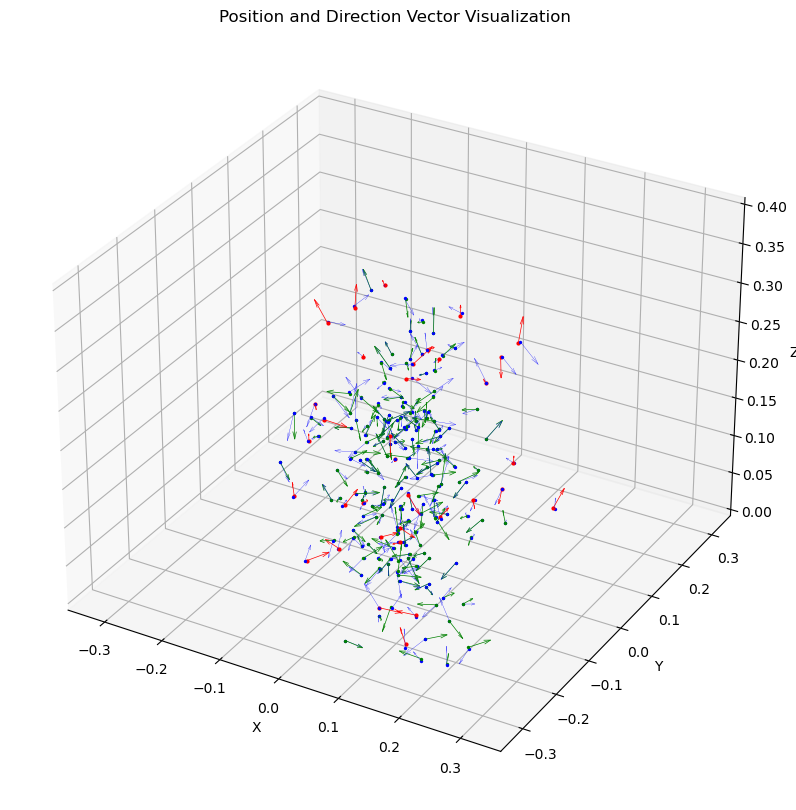

In [14]:
import numpy as np
import matplotlib.pyplot as plt
# Enable interactive plots
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D

# Create a Matplotlib figure and 3D axis with adjusted size
fig = plt.figure(figsize=(10, 10),dpi=100)
ax = fig.add_subplot(111, projection='3d')

# Define the position and direction vectors
for desired_pose in desired_pose_list[:200]:
    pos = np.array([desired_pose.p[0], desired_pose.p[1], desired_pose.p[2]])  # Position vector
    rot = kdl_to_np(desired_pose.M)
    rotvec = R.from_matrix(rot).as_rotvec()
    direction = rotvec  # Direction vector
    # Plot the position vector as a point
    ax.scatter(pos[0], pos[1], pos[2], color='blue', s = 2,alpha=1)
    # Plot the direction vector as an arrow starting from the position
    ax.quiver(pos[0], pos[1], pos[2], direction[0], direction[1], direction[2], color='blue', length=0.012,linewidth=0.2)
for index, solution in enumerate(solutions[:200]):
    pose = kdl.Frame()
    fk_solver.JntToCart(solution, pose)
    pos = np.array([pose.p[0], pose.p[1], pose.p[2]])  # Position vector
    rot = kdl_to_np(pose.M)
    rotvec = R.from_matrix(rot).as_rotvec()
    direction = rotvec  # Direction vector
    # Plot the position vector as a point
    if pos_diffs[index]<0.005 and angle_diffs[index]<np.pi/4:
        ax.scatter(pos[0], pos[1], pos[2], color='green', s = 2,alpha=1)
        # Plot the direction vector as an arrow starting from the position
        ax.quiver(pos[0], pos[1], pos[2], direction[0], direction[1], direction[2], color='green', length=0.012,linewidth=0.5)
    else:
        ax.scatter(pos[0], pos[1], pos[2], color='red', s = 4,alpha=1)
        # Plot the direction vector as an arrow starting from the position
        ax.quiver(pos[0], pos[1], pos[2], direction[0], direction[1], direction[2], color='red', length=0.012,linewidth=0.5)
# Set labels and title
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Position and Direction Vector Visualization')

# Set limits for better visualization (optional)
ax.set_xlim(-0.35, 0.35)
ax.set_ylim(-0.35, 0.35)
ax.set_zlim(0, 0.4)

# Show plot
plt.show()


In [15]:
fk_solver.JntToCart(solution, end_effector_pose )
end_effector_pose 

[[   -0.125446,   0.0415326,    0.991231;
   -0.0512613,    -0.99806,   0.0353313;
     0.990775,  -0.0463797,    0.127331]
[   0.0848975,  0.00302616,  0.00936569]]

In [16]:
q = kdl.JntArray(5)
q[0] = 0
q[1]  = -np.pi/2
# Create a frame to hold the end effector pose result
end_effector_pose = kdl.Frame()

# Calculate forward kinematics
fk_solver.JntToCart(q, end_effector_pose)

0

In [17]:
end_effector_pose

[[           1,-3.67321e-06,-3.67321e-06;
  3.67321e-06, 6.12323e-17,           1;
 -3.67321e-06,          -1, 1.34925e-11]
[ 7.89739e-09,     0.23955,     0.10965]]

In [18]:
# Desired end-effector pose

desired_pose = kdl.Frame(kdl.Rotation.RPY(-np.pi/2, np.pi/2, 0), kdl.Vector(0., 0.2, 0.05))
# Solution joint positions will be stored here
solution = kdl.JntArray(number_of_joints)
q_int = kdl.JntArray(5)
q_int[0]  = -np.arctan2(desired_pose.p[0], desired_pose.p[1])
# Calculate inverse kinematics
status = ik_solver.CartToJnt(q_int, desired_pose, solution)
# while status != 0:
q_int[1]  = np.random.uniform(low=0, high=np.pi)
q_int[2]  = np.random.uniform(low=0, high=np.pi)
q_int[3]  = np.random.uniform(low=0, high=np.pi)
q_int[4]  = np.random.uniform(low=0, high=np.pi)
#     status = ik_solver.CartToJnt(q_int, desired_pose, solution)
print(status)
if status >= 0:
    print("Solution found!") 
    # `solution` now contains the joint positions
else:
    print("No Solution")
fk_solver.JntToCart(solution, end_effector_pose)
print(end_effector_pose)
print(desired_pose)

0
Solution found!
[[  2.0221e-05,          -1,-2.62404e-06;
  -0.00131461,-2.65062e-06,    0.999999;
    -0.999999,-2.02175e-05, -0.00131461]
[-4.24202e-10,    0.199987,   0.0500002]]
[[ 6.12323e-17,          -1, 6.12323e-17;
            0, 6.12323e-17,           1;
           -1,-6.12323e-17,  3.7494e-33]
[           0,         0.2,        0.05]]


In [19]:
solution
print(solution[0],",",solution[1],",",solution[2],",",solution[3],",",solution[4])

-1.0539914381516213e-06 , -1.4417173838255901 , -1.140379481503719 , 1.009985930309614 , 1.5707724312398341


[   -0.463648    -1.62649     -1.1286     2.75507    0.463648]